# TFG: Notebook 1: Analyzing imagesm
---

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pprint
import cv2
import shutil
import os
import random

**Set directories**

In [2]:
train_json = '../Annotations/train.json'
train_data = '/media/arcas/PEN/train/'

In [3]:
with open(train_json, encoding='UTF-8') as json_file:
    data = json.load(json_file)
    pprint.pprint(data[0])

{'answer_type': 'other',
 'answerable': 1,
 'answers': [{'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'}],
 'image': 'VizWiz_train_00000000.jpg',
 'question': "What's the name of this product?"}


**Percentage of total images that are unanswerable**

In [4]:
answerability = [d["answerable"] for d in data]
non_answerable = len(data) - sum(answerability)
non_answble_imgs_percent = (non_answerable / len(data)) * 100
non_answble_imgs_labels = [d["image"] for d in data if d["answerable"] == 0]

print(f"Non-answerable: {non_answerable} imgs = {round(non_answble_imgs_percent, 2)}%")

Non-answerable: 5532 imgs = 26.96%


**Non-answerable sample img**

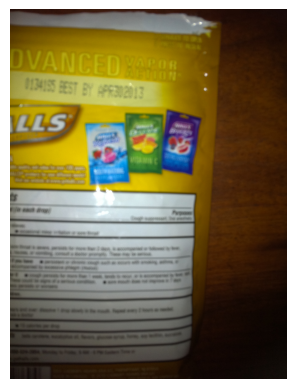

In [118]:
sample_img = non_answble_imgs_labels[1]
img = cv2.imread(train_data + sample_img)
imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(imgc)
plt.axis('off')
plt.show()

## Non-Answerable-Images analysis

Copy the NAI on a separate folder

In [6]:
destination = '../data/NAI_train/'

In [7]:
# Creating storing folders
if not (os.path.isdir(destination)):
    os.mkdir(destination)

In [8]:
if len(os.listdir(destination)) == 0:
    for fs in non_answble_imgs_labels:
        full_file = train_data + fs
        shutil.copy(full_file, destination + fs)
    print("Files moved succesfully!")

### Detect images containing text

In [9]:
import cv2
import pytesseract
 
def find_text(sample_img):
    err_count = 0
    try:
        img = cv2.imread(sample_img)

        # Preprocessing the image starts
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Performing OTSU threshold
        ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

        # Specify structure shape and kernel size.
        # Kernel size increases or decreases the area
        # of the rectangle to be detected.
        # A smaller value like (10, 10) will detect
        # each word instead of a sentence.
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

        # Finding contours
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                         cv2.CHAIN_APPROX_NONE)
        # Creating a copy of image
        im2 = img.copy()

        # A text file is created and flushed
        file = open("recognized.txt", "w+")
        file.write("")
        file.close()

        # Looping through the identified contours
        # Then rectangular part is cropped and passed on
        # to pytesseract for extracting text from it
        # Extracted text is then written into the text file
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)

            # Drawing a rectangle on copied image
            rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Cropping the text block for giving input to OCR
            cropped = im2[y:y + h, x:x + w]

            # Open the file in append mode
            file = open("recognized.txt", "a")

            # Apply OCR on the cropped image
            text = pytesseract.image_to_string(cropped)

            # Appending the text into file
            file.write(text)
            file.write("\n")

            # Close the file
            file.close

        if os.path.getsize("./recognized.txt") > 0:
            return True
        else:
            return False
        
    except:
        err_count += 1

In [10]:
"""
%%time
# Array containing bool values wheather the images had text or not
results = np.array([find_text(destination + img) 
                    for img in non_answble_imgs_labels], dtype=bool)

# Count how many True values (images containing text)
count = np.count_nonzero(results)
perct_of_text = round(count / results.shape[0] * 100, 2)

print(f"Total number of imgs = {results.shape[0]}\nTotal percentage of imgs containing text = {perct_of_text}%")
"""

'\n%%time\n# Array containing bool values wheather the images had text or not\nresults = np.array([find_text(destination + img) \n                    for img in non_answble_imgs_labels], dtype=bool)\n\n# Count how many True values (images containing text)\ncount = np.count_nonzero(results)\nperct_of_text = round(count / results.shape[0] * 100, 2)\n\nprint(f"Total number of imgs = {results.shape[0]}\nTotal percentage of imgs containing text = {perct_of_text}%")\n'

In [124]:
thr = 85
blurred_imgs_labels = []

for img in non_answble_imgs_labels:
    image = cv2.imread(destination + img)
    b = cv2.Laplacian(image, cv2.CV_64F).var()
    if b <= thr:
        blurred_imgs_labels.append(destination + img)
        
len(blurred_imgs_labels)

1994

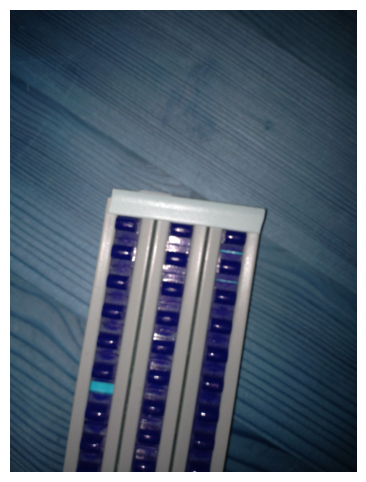

In [133]:
r = random.randint(0, len(blurred_imgs_labels))
random_img = blurred_imgs_labels[r]
plt.figure(figsize=(6, 6))
img = cv2.imread(random_img)
plt.imshow(img)
plt.axis('off')
plt.show()